In [ ]:
%matplotlib inline

In [2]:
%connect_info

{
  "stdin_port": 48364, 
  "ip": "127.0.0.1", 
  "control_port": 55063, 
  "hb_port": 47841, 
  "signature_scheme": "hmac-sha256", 
  "key": "d9ea4869-e8b91de7e993f3af490d679d", 
  "kernel_name": "", 
  "shell_port": 47091, 
  "transport": "tcp", 
  "iopub_port": 37859
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-bb9506ce-ebdd-4b04-a0b6-cab3d0d82eac.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.



# Image denoising using dictionary learning


An example comparing the effect of reconstructing noisy fragments
of a raccoon face image using firstly online `DictionaryLearning` and
various transform methods.

The dictionary is fitted on the distorted left half of the image, and
subsequently used to reconstruct the right half. Note that even better
performance could be achieved by fitting to an undistorted (i.e.
noiseless) image, but here we start from the assumption that it is not
available.

A common practice for evaluating the results of image denoising is by looking
at the difference between the reconstruction and the original image. If the
reconstruction is perfect this will look like Gaussian noise.

It can be seen from the plots that the results of `omp` with two
non-zero coefficients is a bit less biased than when keeping only one
(the edges look less prominent). It is in addition closer from the ground
truth in Frobenius norm.

The result of `least_angle_regression` is much more strongly biased: the
difference is reminiscent of the local intensity value of the original image.

Thresholding is clearly not useful for denoising, but it is here to show that
it can produce a suggestive output with very high speed, and thus be useful
for other tasks such as object classification, where performance is not
necessarily related to visualisation.




In [ ]:
print(__doc__)

from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

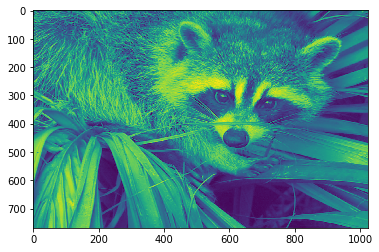

Distorting image...


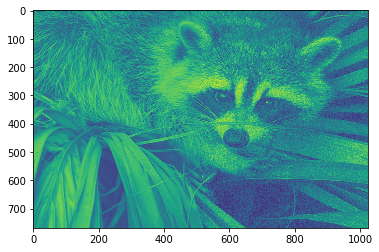

In [67]:
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

plt.figure()
plt.imshow(face, aspect='auto')
plt.show()

# downsample for higher speed
face = face[::2, ::2] + face[1::2, ::2] + face[::2, 1::2] + face[1::2, 1::2]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

plt.figure()
plt.imshow(distorted, aspect='auto')
plt.show()

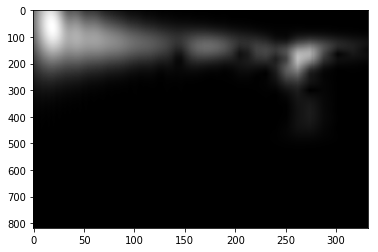

Distorting image...


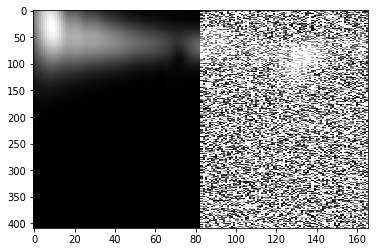

In [101]:
data = np.load('./apr_135135-map.npz')
face = data['tfmap'][:,:int(0.05*16384)]
face /= face.max()
face = face.T
face = face[:-1,:-1]

plt.figure()
plt.imshow(face,vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest', aspect='auto')
plt.clim(0,1)
plt.show()

# downsample for higher speed
face = face[::2, ::2] + face[1::2, ::2] + face[::2, 1::2] + face[1::2, 1::2]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.5*np.random.chisquare(df=2, size=(height, width // 2))
# distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

plt.figure()
plt.imshow(distorted,vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest', aspect='auto')
plt.clim(0,1)
plt.show()

Extracting reference patches...
done in 0.01s.
Learning the dictionary...
done in 2.51s.
Extracting noisy patches... 
done in 0.01s.
Orthogonal Matching Pursuit
1 atom...
done in 1.35s.
Orthogonal Matching Pursuit
2 atoms...
done in 2.46s.
Least-angle regression
5 atoms...
done in 14.55s.
Thresholding
 alpha=0.1...
done in 0.27s.


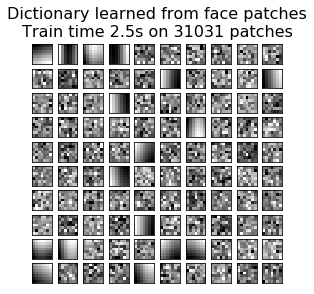

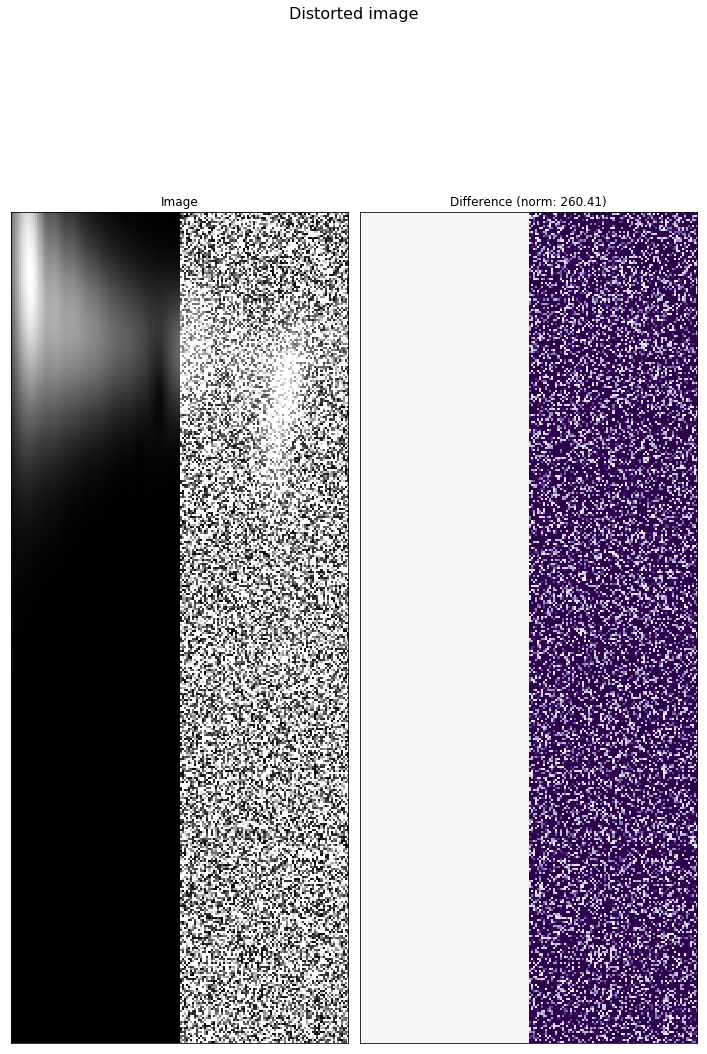

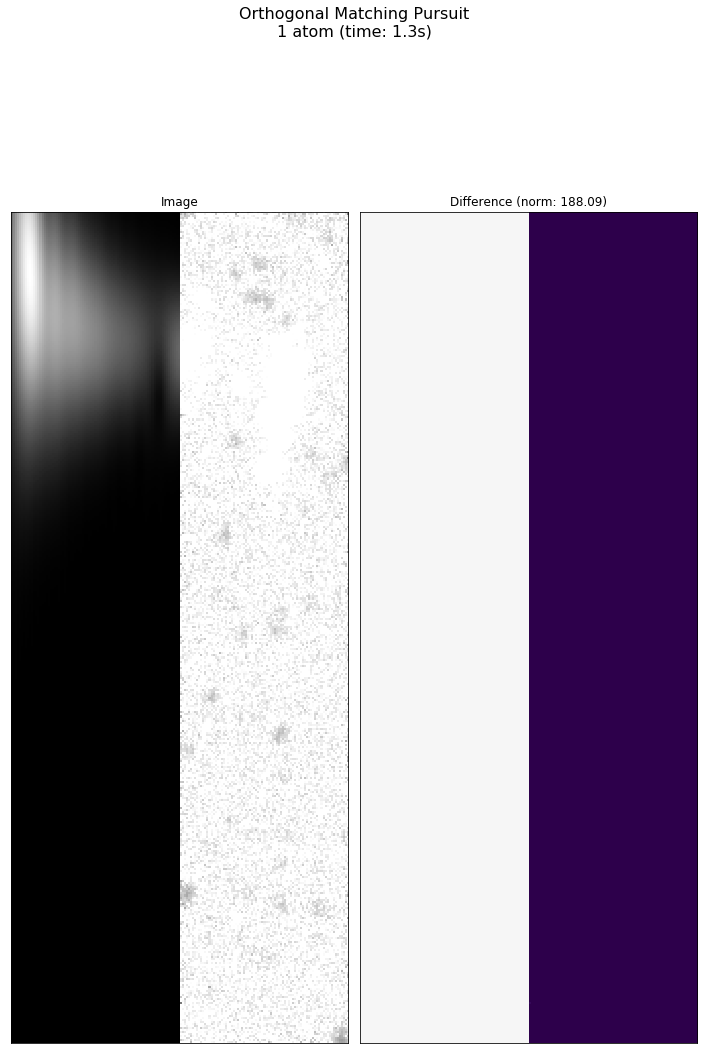

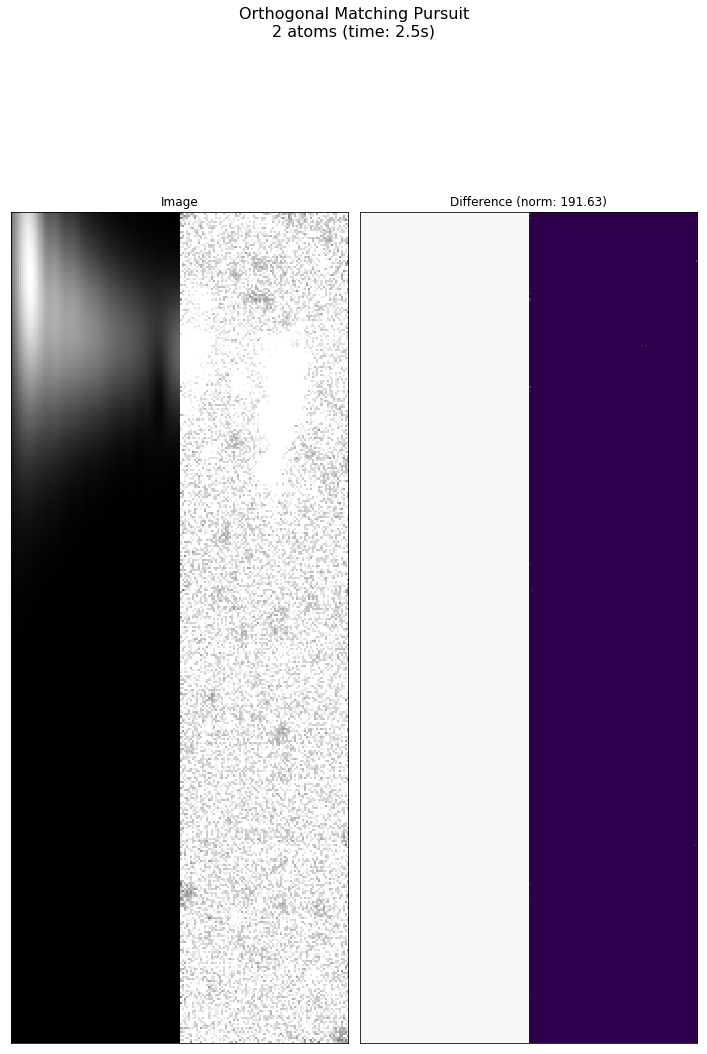

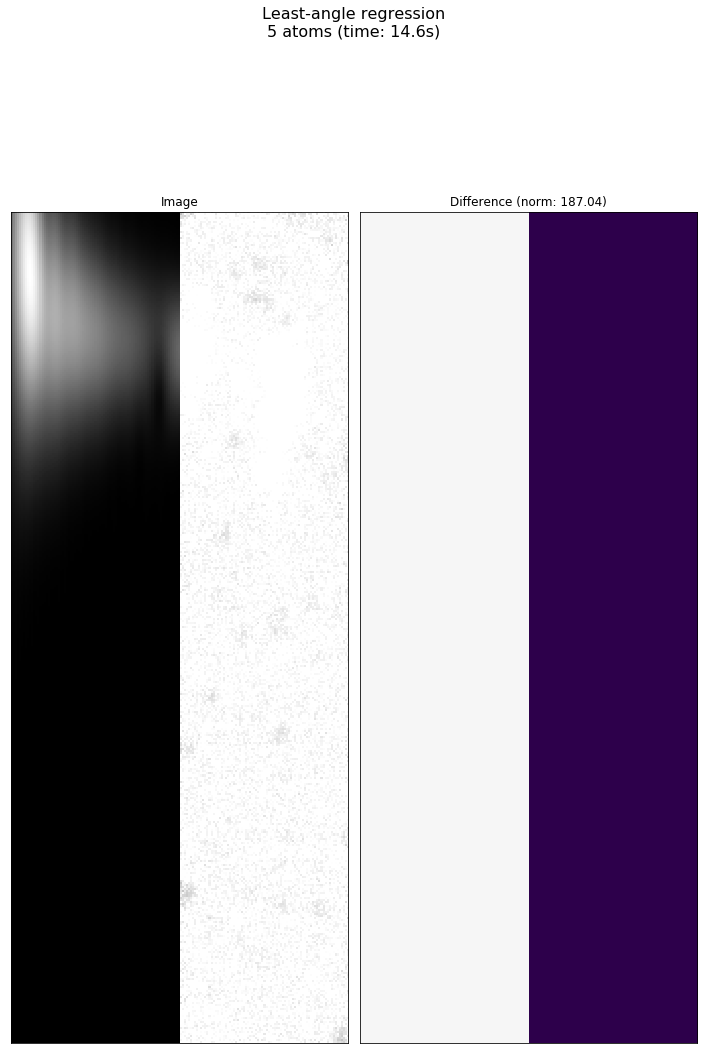

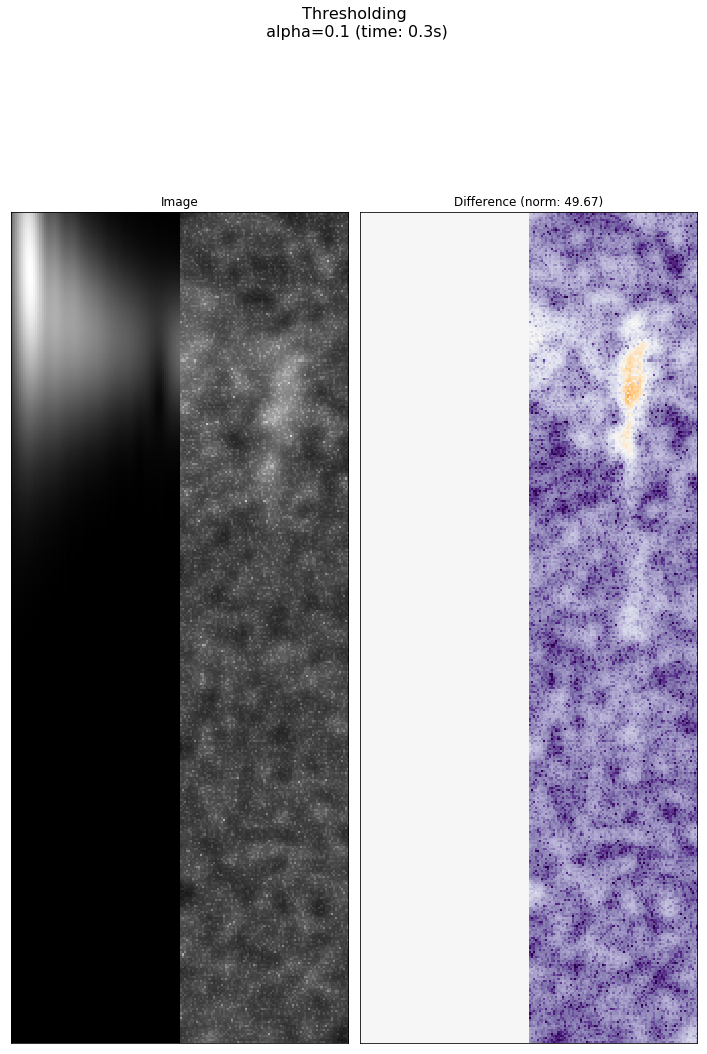

In [102]:


# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(10, 15))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()